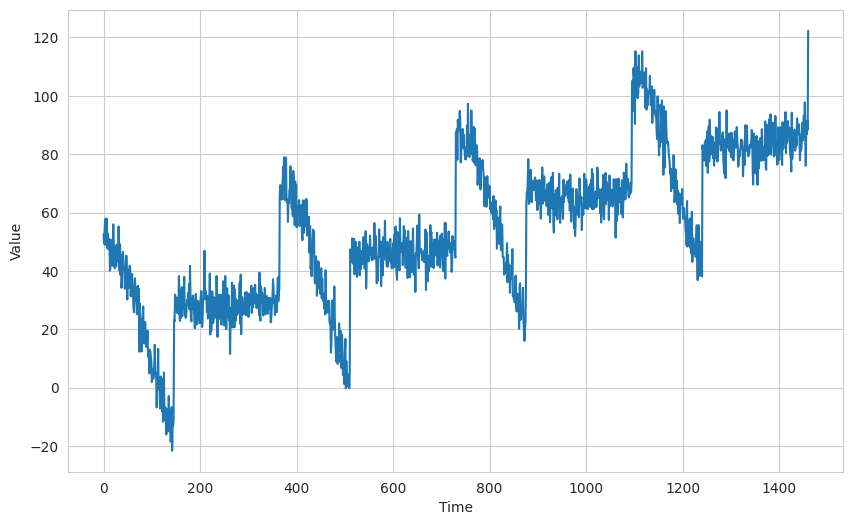

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras


def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40



series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise




plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [ ]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [ ]:
train_set = sequential_window_dataset(X_train,window_size)

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (1, None, 100)            80400     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8*10**(epoch/20))

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [ ]:
reset_states = ResetStatesCallback()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 10s 19ms/step - loss: 105.2442 - mae: 105.7441 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 92.3327 - mae: 92.8326 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 82.3920 - mae: 82.8920 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 71.9207 - mae: 72.4207 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 60.9775 - mae: 61.4775 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 49.0053 - mae: 49.5047 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 36.3311 - mae: 36.8297 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 9ms/step - loss: 26.7934 - mae: 27.2863 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 9ms/step - loss: 23.0515 - mae: 23.5

(1e-08, 0.0001, 0.0, 30.0)

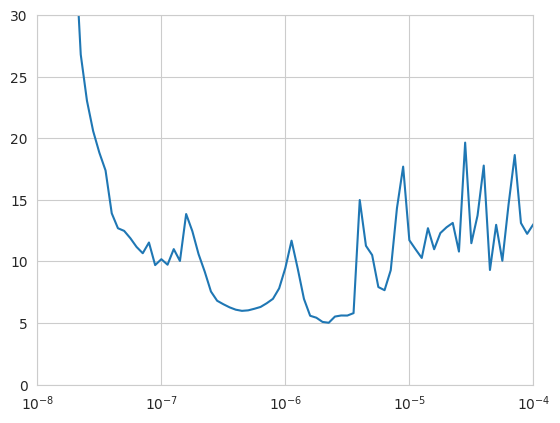

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [ ]:
# Second

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
reset_states = ResetStatesCallback()

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [ ]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,callbacks=[early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 6s 39ms/step - loss: 56.8143 - mae: 57.3128 - val_loss: 41.8663 - val_mae: 42.3649
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 33.7900 - mae: 34.2871 - val_loss: 15.0176 - val_mae: 15.5118
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 42.0001 - mae: 42.4986 - val_loss: 10.9950 - val_mae: 11.4863
Epoch 4/500
33/33 [==============================] - 0s 11ms/step - loss: 19.2503 - mae: 19.7447 - val_loss: 20.3585 - val_mae: 20.8565
Epoch 5/500
33/33 [==============================] - 0s 13ms/step - loss: 10.5334 - mae: 11.0230 - val_loss: 16.4948 - val_mae: 16.9920
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 8.1648 - mae: 8.6549 - val_loss: 9.1959 - val_mae: 9.6855
Epoch 7/500
33/33 [==============================] - 0s 12ms/step - loss: 9.1633 - mae: 9.6516 - val_loss: 10.0911 - val_mae: 10.5807
Epoch 8/500
33/33 [==============================] - 0

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])

1/1 [==============================] - 1s 1s/step


In [ ]:
rnn_forecast = rnn_forecast[0,split_time-1:-1,0]

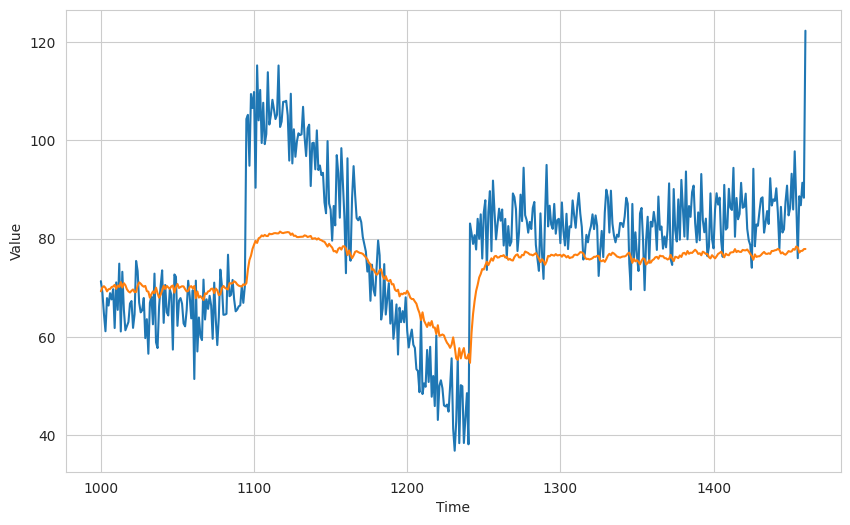

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

In [ ]:
# Forecasting With CNN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)


train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),])

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 9s 24ms/step - loss: 17.9218 - mae: 18.4166 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 17.4883 - mae: 17.9833 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 17.1381 - mae: 17.6326 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 16.7096 - mae: 17.2038 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 16.3103 - mae: 16.8041 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 15.9706 - mae: 16.4644 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 15.6722 - mae: 16.1660 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 15.4194 - mae: 15.9127 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 15.1955 - mae: 15.6889 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

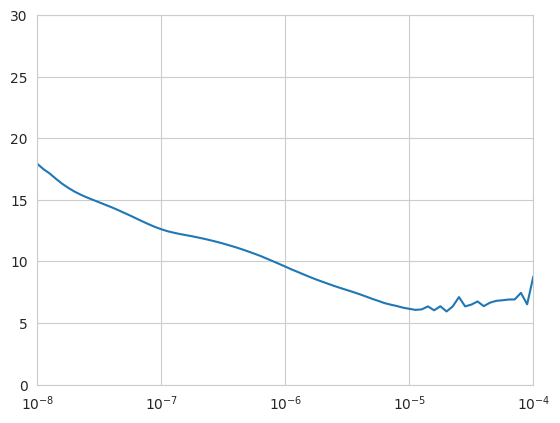

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [ ]:
# SEcond

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [ ]:

train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,
             metrics=['mae'])

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set,epochs=500,validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 160ms/step - loss: 49.8436 - mae: 50.3422 - val_loss: 19.4032 - val_mae: 19.8994
Epoch 2/500
8/8 [==============================] - 0s 34ms/step - loss: 23.2278 - mae: 23.7236 - val_loss: 48.1867 - val_mae: 48.6867
Epoch 3/500
8/8 [==============================] - 0s 35ms/step - loss: 16.5622 - mae: 17.0558 - val_loss: 23.8846 - val_mae: 24.3827
Epoch 4/500
8/8 [==============================] - 0s 26ms/step - loss: 13.7516 - mae: 14.2457 - val_loss: 34.7432 - val_mae: 35.2425
Epoch 5/500
8/8 [==============================] - 0s 34ms/step - loss: 11.8019 - mae: 12.2921 - val_loss: 22.7842 - val_mae: 23.2813
Epoch 6/500
8/8 [==============================] - 0s 25ms/step - loss: 10.1995 - mae: 10.6892 - val_loss: 24.3388 - val_mae: 24.8365
Epoch 7/500
8/8 [==============================] - 0s 38ms/step - loss: 8.8402 - mae: 9.3269 - val_loss: 19.0996 - val_mae: 19.5961
Epoch 8/500
8/8 [==============================] - 0s 30ms/step

In [ ]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model_forcast(model,series[:,np.newaxis],window_size)

45/45 [==============================] - 1s 8ms/step


In [ ]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

In [ ]:
rnn_forecast

array([64.39396 , 65.066734, 65.639   , 66.25175 , 65.93297 , 66.35616 ,
       66.088486, 66.99469 , 66.6597  , 66.67139 , 66.15702 , 67.20337 ,
       66.60061 , 67.34123 , 66.425514, 67.66183 , 65.6692  , 66.91958 ,
       65.9925  , 65.275185, 65.65871 , 66.03655 , 65.371475, 65.624725,
       66.41818 , 66.61224 , 66.78348 , 67.19315 , 66.97996 , 66.96255 ,
       65.93485 , 65.94803 , 63.9235  , 64.75667 , 64.06265 , 64.235   ,
       65.13018 , 63.941895, 64.54393 , 63.818813, 64.084366, 64.45458 ,
       64.6975  , 66.21179 , 64.99154 , 66.51684 , 66.89179 , 66.972755,
       66.17005 , 66.56149 , 66.33223 , 66.857994, 66.71558 , 65.60785 ,
       66.44756 , 66.33051 , 65.89079 , 65.469055, 65.966034, 66.41544 ,
       66.5858  , 67.13261 , 63.94376 , 65.46413 , 61.88048 , 63.366745,
       62.552273, 63.259613, 63.45532 , 62.87169 , 63.697506, 64.068504,
       65.00825 , 65.51764 , 65.23442 , 65.6109  , 64.97411 , 65.42848 ,
       63.93137 , 64.75157 , 65.32202 , 65.418106, 

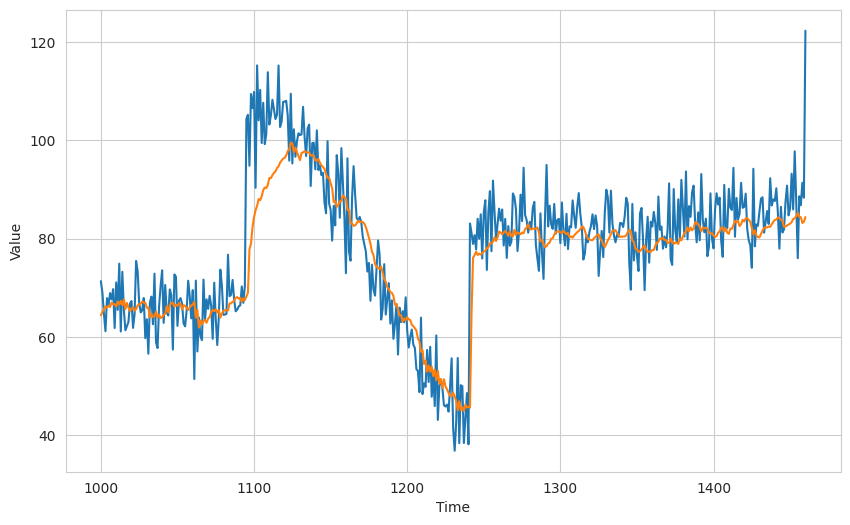

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

In [ ]:
# Fully Convolutional Forcasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [ ]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [ ]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 66ms/step - loss: 39.9748 - mae: 40.4740 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 39.4103 - mae: 39.9094 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 38.6989 - mae: 39.1977 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 37.7756 - mae: 38.2740 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 36.5072 - mae: 37.0052 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 34.6127 - mae: 35.1114 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 31.6630 - mae: 32.1612 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 27.0297 - mae: 27.5277 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 20.0490 - mae: 20.5442 - lr: 1.8478e

(0.0001, 0.1, 0.0, 30.0)

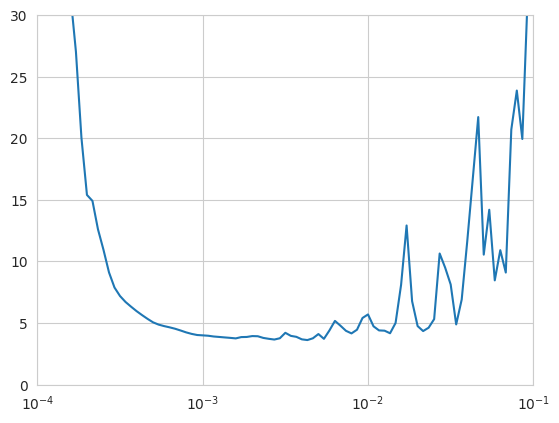

In [ ]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [ ]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)

In [ ]:
model.compile(loss=keras.callbacks.EarlyStopping(patience=50))
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)
history = model.fit(train_set,epochs=500,validation_data=valid_set,
                   callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 128ms/step - loss: 41.0713 - mae: 41.5704 - val_loss: 75.0321 - val_mae: 75.5321
Epoch 2/500
8/8 [==============================] - 0s 39ms/step - loss: 39.5670 - mae: 40.0661 - val_loss: 71.9134 - val_mae: 72.4134
Epoch 3/500
8/8 [==============================] - 0s 38ms/step - loss: 37.6809 - mae: 38.1794 - val_loss: 67.4742 - val_mae: 67.9742
Epoch 4/500
8/8 [==============================] - 0s 39ms/step - loss: 34.8066 - mae: 35.3051 - val_loss: 60.3042 - val_mae: 60.8042
Epoch 5/500
8/8 [==============================] - 0s 38ms/step - loss: 30.0554 - mae: 30.5535 - val_loss: 47.9157 - val_mae: 48.4157
Epoch 6/500
8/8 [==============================] - 0s 40ms/step - loss: 22.2125 - mae: 22.7092 - val_loss: 27.6549 - val_mae: 28.1510
Epoch 7/500
8/8 [==============================] - 0s 31ms/step - loss: 15.4265 - mae: 15.9178 - val_loss: 25.0764 - val_mae: 25.5728
Epoch 8/500
8/8 [==============================] - 0s 31ms/st

In [ ]:
cnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

44/44 [==============================] - 1s 11ms/step


In [ ]:
cnn_forecast = cnn_forecast[split_time-window_size:-1,-1,0]

TypeError: ignored

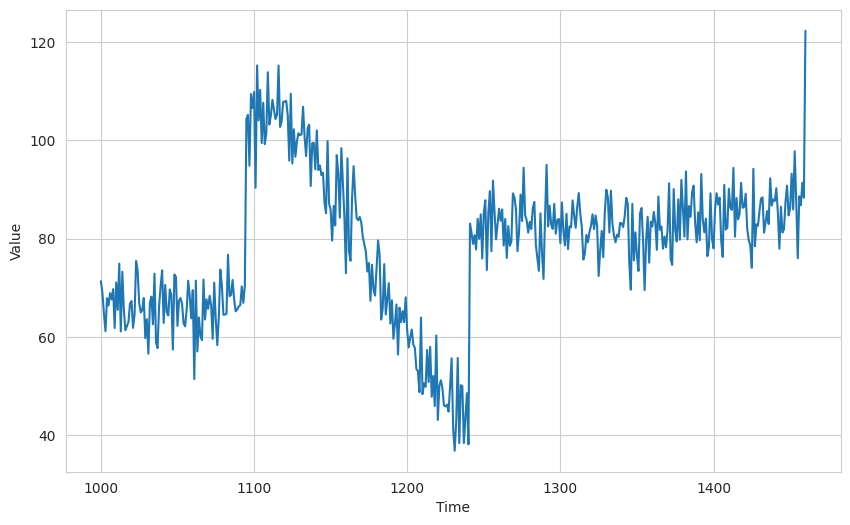

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series()